In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import ExpSineSquared
import scipy
import pandas as pd
from scipy.optimize import differential_evolution
import warnings
warnings.filterwarnings("ignore")

In [2]:
def target(x):
    """
    Function to optimise
    """
    f = np.sin( 3 * np.pi * x**3) - 0.5 * np.sin(8 * np.pi * x**3)
    f /= 2
    return f

In [28]:
dict_dataset = {}
dict_dataset['x'] =  [0.1, 0.5, 0.75, 0.2, 0.59]
dict_dataset['y'] =  [-0.0015702, 0.46193977, -0.13950568, -0.01226409, 0.69227033]  
dataset = pd.DataFrame(dict_dataset)

In [29]:
dataset

,x,y
0,0.10,-0.001570
1,0.50,0.461940
2,0.75,-0.139506
3,0.20,-0.012264
4,0.59,0.692270


In [30]:
dataset = dataset.sort_values(by=['x'])

In [6]:
dataset

,x,y
0,0.10,-0.001570
3,0.20,-0.012264
1,0.50,0.461940
4,0.59,0.692270
2,0.75,-0.139506


In [7]:
def phi(x):
    return scipy.stats.norm.pdf(x)

def Phi(x):
    return scipy.stats.norm.cdf(x)

def EI(mu, sigma, f_best):
    s = (f_best - mu)/sigma
    return (sigma*s * Phi(s) + sigma*phi(s))
    
def PI(mu, sigma,f_best):
    s = (f_best - mu)/sigma
    return (Phi(s))

def LCB(mu, sigma,beta):
    return (mu - beta*sigma)

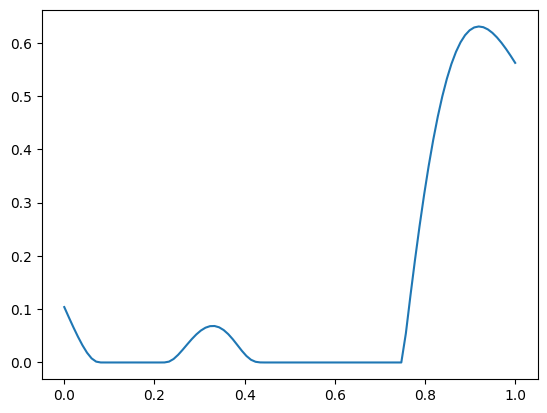

In [145]:
plt.plot(x,result)

In [8]:
X = dataset['x'].to_numpy().reshape(-1,1)
Y = dataset['y'].to_numpy().reshape(-1,1)
kernel = RBF(length_scale=0.1,length_scale_bounds=(0.1,100)) 
model = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=95).fit(X,Y)

In [137]:
#model.get_params(deep=True)
model.kernel_.get_params()

{'length_scale': 0.17365884651992644, 'length_scale_bounds': (0.1, 100)}

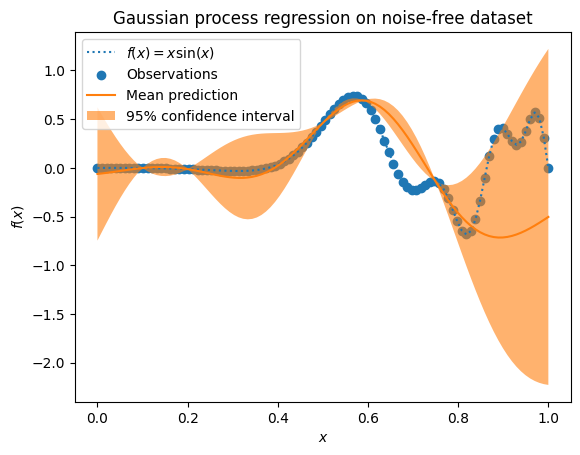

In [9]:
x  = np.linspace(0,1,100)
x =x.reshape(-1,1)
Y = target(x)
#model.fit(x,Y)
mean_prediction, std_prediction = model.predict(x, return_std=True)
plt.plot(x, Y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(x, Y, label="Observations")
plt.plot(x, mean_prediction, label="Mean prediction")
plt.fill_between(
    x.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.6,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on noise-free dataset")

In [10]:
x  = np.linspace(0,1,100)
mean,std = model.predict(x.reshape(-1,1),return_std=True)

In [11]:
result  = PI(mean,std,min(list(dataset['y'])))

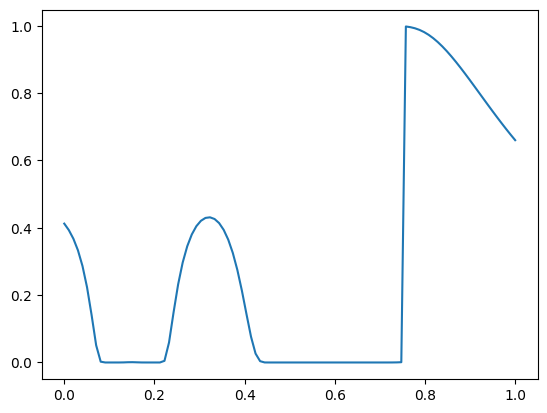

In [12]:
plt.plot(x,result)

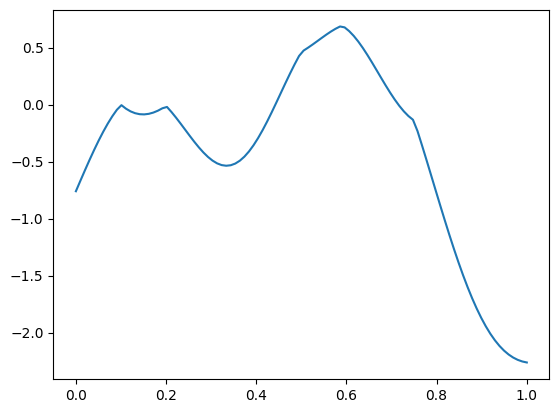

In [13]:
x  = np.linspace(0,1,100)
mean,std = model.predict(x.reshape(-1,1),return_std=True)
result  = LCB(mean,std,2)
plt.plot(x,result)


In [14]:
def EI_2(x,model,f_best):
    x= x.reshape(-1,1)
    mu,sigma = model.predict(x,return_std=True)
    mu = mu
    sigma = sigma
    s = (f_best - mu)/sigma
    return -(sigma*s * Phi(s) + sigma*phi(s))


In [31]:
from scipy import optimize
from scipy.optimize import Bounds
bounds = [(0,1)]
regret = []
fbest_global = min(dataset['y'])
for i in range(30):
    X,Y = dataset['x'],dataset['y']
    X= X.to_numpy().reshape(-1,1)
    Y= Y.to_numpy().reshape(-1,1)
    model = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=95).fit(X,Y)
    fbest = min(dataset['y'])
    res = optimize.differential_evolution(EI_2,bounds=bounds,args=(model,fbest))
    result = res.x[0]
    y_new = target(result)
    dataset.loc[len(dataset.index)]=[result,y_new]
    regret.append(min(dataset['y'])-fbest_global)
    




In [22]:
dataset

,x,y
0,0.100000,-1.570200e-03
3,0.200000,-1.226409e-02
1,0.500000,4.619398e-01
4,0.590000,6.922703e-01
2,0.750000,-1.395057e-01
5,0.919749,2.716496e-01
6,0.338671,-2.811428e-02
7,0.801261,-5.840491e-01
8,0.000000,0.000000e+00
9,0.821701,-6.801088e-01


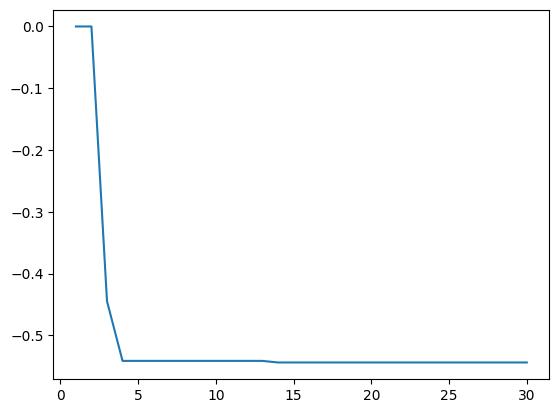

In [32]:
plt.plot(list(range(1,31)),regret)